#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, cv

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df = df.resample('1H').sum()

## Анализ

**В датасете лежат данные с марта 2018 по август 2018**

In [7]:
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
display(df.tail())

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


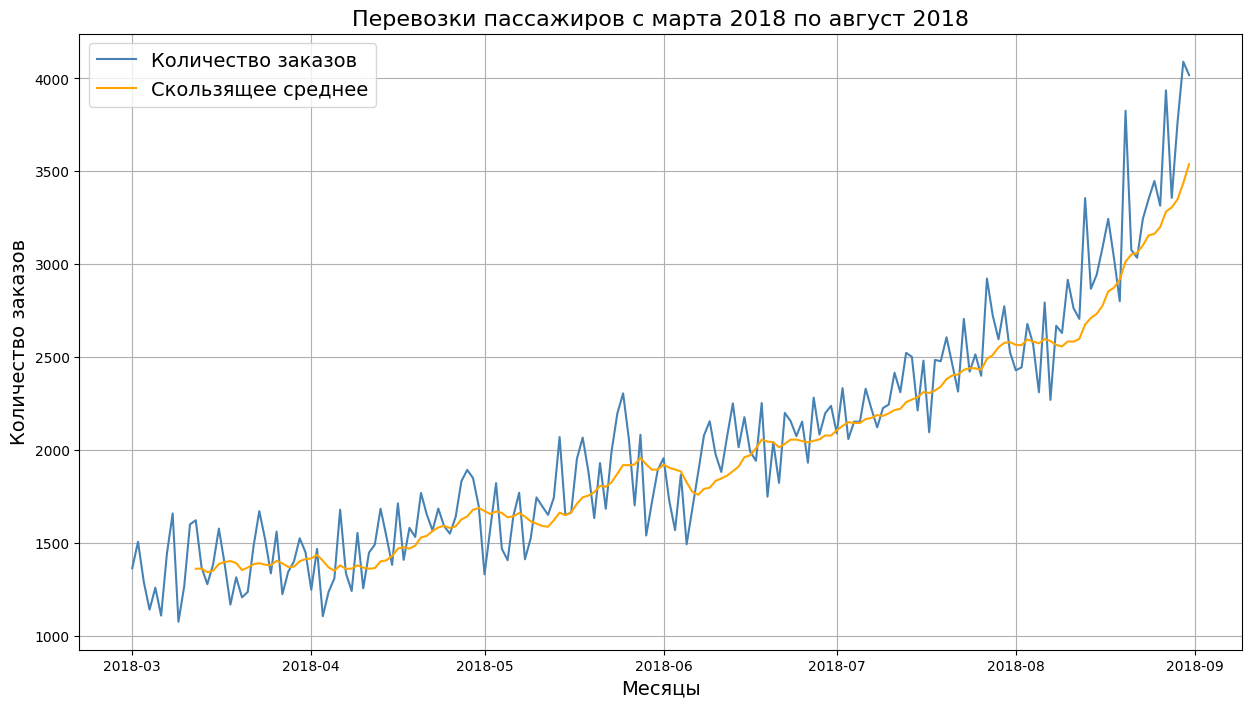

In [22]:
plt.figure(figsize = (15,8))
plt.grid()
 
plt.plot(df.resample('1D').sum(), label = 'Количество заказов', color = 'steelblue')
plt.plot(df.resample('1D').sum().rolling(window = 12).mean(), label = 'Скользящее среднее', color = 'orange')
 
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество заказов', fontsize = 14)
plt.title('Перевозки пассажиров с марта 2018 по август 2018', fontsize = 16)
 
plt.show()

### Визуализация тренда

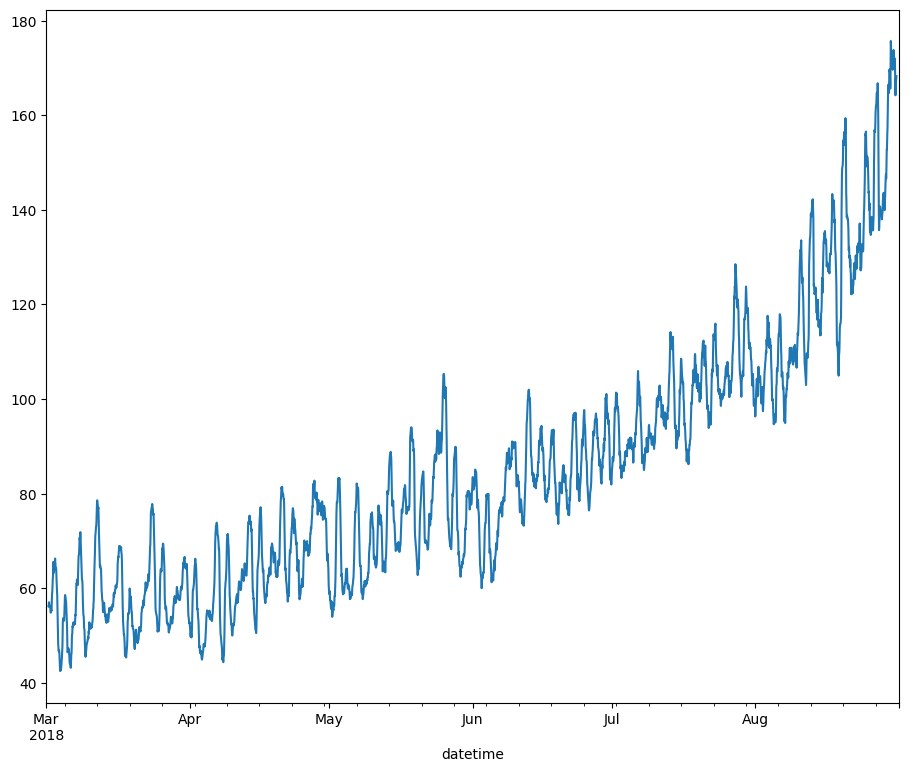

In [10]:
decomposed = seasonal_decompose(df)
rcParams['figure.figsize'] = 11, 9
decomposed.trend.plot();

### Визуализация сезонности

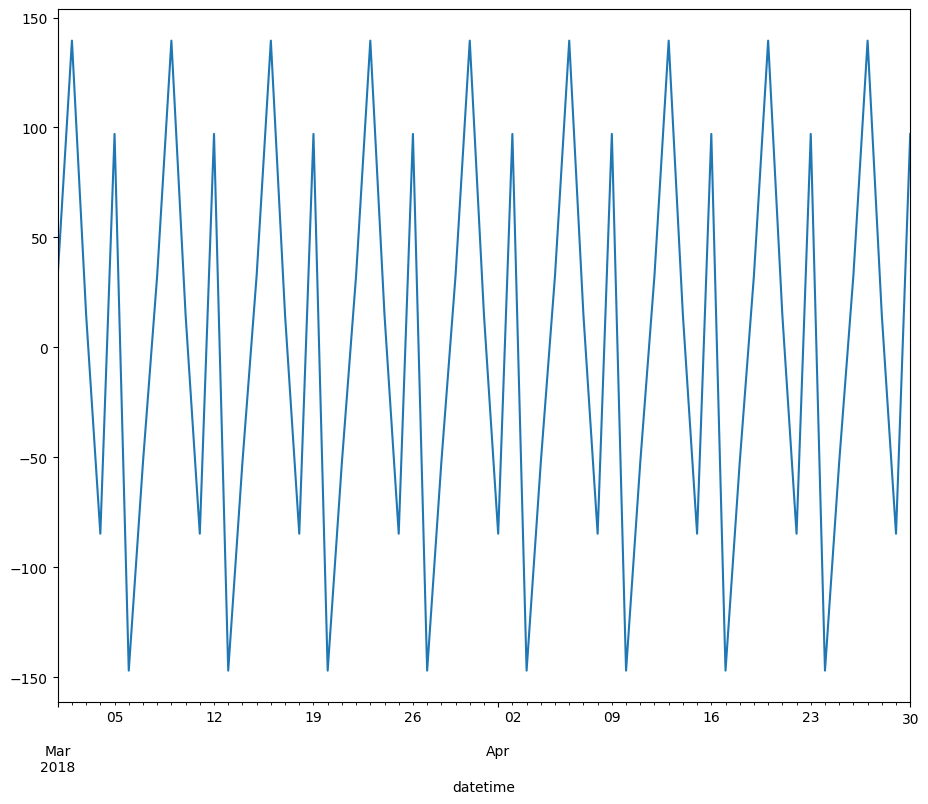

In [11]:
seasonal = df.resample('1D').sum()
decomposed = seasonal_decompose(seasonal['2018-03':'2018-04'])
rcParams['figure.figsize'] = 11, 9
decomposed.seasonal.plot();

In [12]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Создание новых признаков

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = data.index.year
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    new_data['std'] = new_data['num_orders'].rolling(rolling_mean_size).std()
    return new_data

new_df = make_features(df, 24, 24)

new_df = new_df.dropna().reset_index()

In [14]:
new_df = new_df.set_index('datetime')

## Обучение алгоритмов

In [15]:
X = new_df.drop('num_orders', axis=1)
y = new_df['num_orders']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

### Функция кроссвалидации для временных рядов

In [17]:
def time_series_cross_val_score(model, X_train, y_train):
    errors = []
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(X_train):
        model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        pred = model.predict(X_train.iloc[test_index])
        errors.append(mean_squared_error(y_train.iloc[test_index], pred, squared=False))
    return np.mean(errors)

### LGBMRegressor

In [18]:
lgbm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=1))
])

In [19]:
def LGBM_time_series_cross_val_score(model, params, X_train, y_train):
    grid_model = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit().split(X_train))
    grid_model.fit(X_train, y_train)
    return grid_model.best_score_, grid_model.best_params_

params = {
    'model__max_depth':range(8, 17, 2),
    'model__num_leaves':range(12, 17, 2)
}

print('Средняя оценка качества модели на кроссвалидации и лучшие параметры:', LGBM_time_series_cross_val_score(lgbm_pipe, params, X_train, y_train))

Средняя оценка качества модели на кроссвалидации и лучшие параметры: (-25.445656629875316, {'model__max_depth': 10, 'model__num_leaves': 12})


### CatBoostRegressor

In [20]:
cat_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_state=1, loss_function='RMSE', verbose=False))
])

In [23]:
print('Средняя оценка качества модели на кроссвалидации:', time_series_cross_val_score(cat_pipe, X_train, y_train))

Средняя оценка качества модели на кроссвалидации: 24.676779087195268


### LinearRegressor

In [24]:
lin_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [25]:
print('Средняя оценка качества модели на кроссвалидации:', time_series_cross_val_score(lin_pipe, X_train, y_train))

Средняя оценка качества модели на кроссвалидации: 33418720235306.594


### GradientBoostingRegressor

In [26]:
gradient_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=1))
])

In [27]:
print('Средняя оценка качества модели на кроссвалидации:', time_series_cross_val_score(gradient_pipe, X_train, y_train))

Средняя оценка качества модели на кроссвалидации: 26.04960937562795


**Самой точной моделью является CatBoostRegressor**

## Тестирование

In [28]:
cat_pipe.fit(X_train, y_train)
pred = cat_pipe.predict(X_test)

print('RMSE =', mean_squared_error(y_test, pred, squared=False))

RMSE = 41.28913723695858


## Вывод

**В датасете лежат данные с марта по август 2018 года, на основе анализа графика распределения заказов по дням за этот период намечается тренд на увеличение количества заказов такси. Для предсказания количества заказов в будущем обучалось несколько моделей: LGBMRegressor, CatBoostRegressor, LinearRegressior и GradientBoostingRegressor. Модели сравнивались метрикой RMSE по результатам кроссвалидации,лучшей моделью оказалась CatBoostRegressor, на валидационной выборке получилось достичь значение RMSE меньше 48**